<a href="https://colab.research.google.com/github/COMM599-Fall2023/fall_2023/blob/yueqihua-final-project/student%20folders/yueqihua/final/predictive_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Modeling

---

*Includes preprocessing and predictive modeling for a classifier and regressor model*

*   Input: twitch_data.csv, game_data.csv
*   No output

## Install dependencies, import modules, input credentials

In [109]:
!pip install pandas
!pip install --upgrade scikit-learn
!pip install scikit-optimize
!pip install xgboost
!pip install shap

In [ ]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import set_config
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

import shap
import pickle
from skopt import BayesSearchCV
import xgboost as xgb

## Preprocessing

In [116]:
# load csvs

twitch_df = pd.read_csv("datasets/twitch_data.csv", encoding='utf-8-sig', index_col=0)
# cleaning up
twitch_df['month'] = twitch_df['month'].apply(lambda x: f"{x:02d}")
twitch_df['year'] = twitch_df['year'].astype(str)
twitch_df = twitch_df[['rank', 'game', 'month', 'year']]

game_data_df = pd.read_csv("datasets/game_data.csv", encoding='utf-8-sig', index_col=0)
# cleaning up
columns_to_drop = ['appid', 'is_free', 'description', 'publishers', 'score']
game_data_df = game_data_df.drop(columns=columns_to_drop)

In [117]:
set_config(transform_output="pandas")

##### Generating developer, platform, and genre tags

In [118]:
to_encode = ['developers', 'platforms', 'genres']

In [119]:
def custom_tokenizer(text):
    return text.split()

for column in to_encode :
    column_list = f"{column}_list"

    # some bad values e.g. spaces or parentheses in developers
    game_data_df[column] = game_data_df[column].str.replace(r'\s\(.*\)', '', regex=True)
    game_data_df[column] = game_data_df[column].replace({'CO. ': '', 'Co. ': ''}, regex=True)
    game_data_df[column_list] = game_data_df[column].str.split(', ')
    game_data_df[column_list] = game_data_df[column_list].apply(
        lambda values: [value.replace(' ', '_') for value in values])
    game_data_df[column_list] = game_data_df[column_list].apply(
        lambda values: ' '.join(values))

    if column == 'developers' :
        vect = CountVectorizer(max_features=25, tokenizer=custom_tokenizer) # limit developers to top 25
    else :
        vect = CountVectorizer(tokenizer=custom_tokenizer)

    fit_vect = vect.fit(game_data_df[column_list])

    X =  fit_vect.transform(game_data_df[column_list])
    feature_names = vect.get_feature_names_out()

    game_data_df = game_data_df.join(pd.DataFrame(X.toarray(), columns=feature_names))

    game_data_df = game_data_df.drop(column, axis=1)
    game_data_df = game_data_df.drop(column_list, axis=1)

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
The parameter 'token_pattern' will not be used since 'tokenizer' is not None'


In [120]:
columns_to_drop = ['llc', 'ltd', 'ltd.', 'inc', 'inc.'] # columns that are not relevant
for column in columns_to_drop:
    if column in game_data_df.columns:
        game_data_df = game_data_df.drop(columns=column)

In [121]:
game_data_df # 1040 x 45

,game,release_date,required_age,price,arkane_studios,aspyr,bethesda_game_studios,capco.,capcom,feral_interactive,...,indie,massively_multiplayer,nudity,racing,rpg,sexual_content,simulation,sports,strategy,violent
0,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Call of Duty: Black Ops III,2015-11-05,17,19.79,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,World of Tanks,2021-04-28,0,0.00,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,Tom Clancy's Rainbow Six Siege,2015-12-01,17,19.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,RuneScape,2020-10-14,0,0.00,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,Dragonheir: Silent Gods,2023-10-26,0,0.00,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1036,Warhaven,2023-09-20,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1037,Town of Salem 2,2023-08-25,0,0.00,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1038,I'm on Observation Duty 6,2023-09-01,0,11.99,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [122]:
game_data_df.dtypes

game                           object
release_date                   object
required_age                    int64
price                         float64
arkane_studios                  int64
aspyr                           int64
bethesda_game_studios           int64
capco.                          int64
capcom                          int64
feral_interactive               int64
firaxis_games                   int64
frontier_developments           int64
jackbox_games                   int64
obsidian_entertainment          int64
paradox_development_studio      int64
qloc                            int64
ryu_ga_gotoku_studio            int64
saber_interactive               int64
spike_chunsoft_co.              int64
square_enix                     int64
supermassive_games              int64
team17                          int64
telltale_games                  int64
ubisoft_montreal                int64
valve                           int64
visual_concepts                 int64
linux       

##### Creating merged df of game information for each Twitch dataset month

In [123]:
time_df = twitch_df[['month', 'year']].drop_duplicates() # df for all months between 2016-01 and 2023-09
time_df['period'] = time_df['year'] + '-' + time_df['month']
time_df = time_df.reset_index(drop=True)

time_df # 93

,month,year,period
0,01,2016,2016-01
1,02,2016,2016-02
2,03,2016,2016-03
3,04,2016,2016-04
4,05,2016,2016-05
...,...,...,...
88,05,2023,2023-05
89,06,2023,2023-06
90,07,2023,2023-07
91,08,2023,2023-08


In [124]:
game_data_df['key'] = 0
time_df['key'] = 0

merged_df = game_data_df.merge(time_df, on='key') # df that has data for each month for each game

game_data_df = game_data_df.drop(columns='key')
time_df = time_df.drop(columns='key')
merged_df = merged_df.drop(columns='key')

In [125]:
merged_df # 926720 x 48

,game,release_date,required_age,price,arkane_studios,aspyr,bethesda_game_studios,capco.,capcom,feral_interactive,...,racing,rpg,sexual_content,simulation,sports,strategy,violent,month,year,period
0,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,01,2016,2016-01
1,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,02,2016,2016-02
2,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,03,2016,2016-03
3,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,04,2016,2016-04
4,Dota 2,2013-07-09,0,0.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,05,2016,2016-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96715,Deceit 2,2023-09-14,0,9.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,05,2023,2023-05
96716,Deceit 2,2023-09-14,0,9.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,06,2023,2023-06
96717,Deceit 2,2023-09-14,0,9.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,07,2023,2023-07
96718,Deceit 2,2023-09-14,0,9.99,0,0,0,0,0,0,...,0,0,0,0,0,0,0,08,2023,2023-08


In [126]:
# extracting months and years from release_date

merged_df['release_period'] = merged_df['release_date'].str.extract(r'(\d{4}-\d{2})')

merged_df['release_month'] = merged_df['release_period'].str.extract(r'(\d{2}$)')
merged_df['release_year'] = merged_df['release_period'].str.extract(r'(^\d{4})')

In [127]:
# removing rows where the release_period > period

merged_df = merged_df[merged_df['release_period'] <= merged_df['period']]
merged_df = merged_df.reset_index(drop=True)

In [128]:
# calculating months since release

def calculate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')

    delta = relativedelta(end_date, start_date)
    months = delta.years * 12 + delta.months

    return months

merged_df['months_since_release'] = merged_df.apply(
    lambda row: calculate_months(row['release_period'], row['period']), axis=1)

In [129]:
columns_to_drop = ['release_date', 'period', 'release_period']
merged_df = merged_df.drop(columns=columns_to_drop)

merged_df # 52498 x 49

,game,required_age,price,arkane_studios,aspyr,bethesda_game_studios,capco.,capcom,feral_interactive,firaxis_games,...,sexual_content,simulation,sports,strategy,violent,month,year,release_month,release_year,months_since_release
0,Dota 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,01,2016,07,2013,30
1,Dota 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,02,2016,07,2013,31
2,Dota 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,03,2016,07,2013,32
3,Dota 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,04,2016,07,2013,33
4,Dota 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,05,2016,07,2013,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52493,Warhaven,0,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,09,2023,09,2023,0
52494,Town of Salem 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,08,2023,08,2023,0
52495,Town of Salem 2,0,0.00,0,0,0,0,0,0,0,...,0,0,0,1,0,09,2023,08,2023,1
52496,I'm on Observation Duty 6,0,11.99,0,0,0,0,0,0,0,...,0,0,0,0,0,09,2023,09,2023,0


In [130]:
twitch_df

,rank,game,month,year
0,3,Dota 2,01,2016
1,5,Call of Duty: Black Ops III,01,2016
2,15,World of Tanks,01,2016
3,16,Tom Clancy's Rainbow Six Siege,01,2016
4,17,RuneScape,01,2016
...,...,...,...,...
8066,190,I'm on Observation Duty 6,09,2023
8067,191,Deceit 2,09,2023
8068,194,Valheim,09,2023
8069,196,PlateUp!,09,2023


##### Merging merged_df with twitch_df

In [131]:
final_df = merged_df.merge(twitch_df, on=['game', 'month', 'year'], how='left') # adding twitch rank data to the time x game df for context
final_df = final_df.drop('game', axis=1)

# cleaning
final_df['rank'] = final_df['rank'].fillna(0).astype(int)
final_df['month'] = final_df['month'].astype(int)
final_df['year'] = final_df['year'].astype(int)
final_df['release_month'] = final_df['release_month'].astype(int)
final_df['release_year'] = final_df['release_year'].astype(int)

# creating month year interaction to handle temporal values
final_df['month_year_interaction'] = final_df['month'] * final_df['year']
final_df['release_month_year_interaction'] = final_df['release_month'] * final_df['release_year']

final_df # 52503 x 51

,required_age,price,arkane_studios,aspyr,bethesda_game_studios,capco.,capcom,feral_interactive,firaxis_games,frontier_developments,...,strategy,violent,month,year,release_month,release_year,months_since_release,rank,month_year_interaction,release_month_year_interaction
0,0,0.00,0,0,0,0,0,0,0,0,...,1,0,1,2016,7,2013,30,3,2016,14091
1,0,0.00,0,0,0,0,0,0,0,0,...,1,0,2,2016,7,2013,31,3,4032,14091
2,0,0.00,0,0,0,0,0,0,0,0,...,1,0,3,2016,7,2013,32,3,6048,14091
3,0,0.00,0,0,0,0,0,0,0,0,...,1,0,4,2016,7,2013,33,3,8064,14091
4,0,0.00,0,0,0,0,0,0,0,0,...,1,0,5,2016,7,2013,34,3,10080,14091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52498,0,0.00,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,172,18207,18207
52499,0,0.00,0,0,0,0,0,0,0,0,...,1,0,8,2023,8,2023,0,0,16184,16184
52500,0,0.00,0,0,0,0,0,0,0,0,...,1,0,9,2023,8,2023,1,183,18207,16184
52501,0,11.99,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,190,18207,18207


In [132]:
final_df.dtypes

required_age                        int64
price                             float64
arkane_studios                      int64
aspyr                               int64
bethesda_game_studios               int64
capco.                              int64
capcom                              int64
feral_interactive                   int64
firaxis_games                       int64
frontier_developments               int64
jackbox_games                       int64
obsidian_entertainment              int64
paradox_development_studio          int64
qloc                                int64
ryu_ga_gotoku_studio                int64
saber_interactive                   int64
spike_chunsoft_co.                  int64
square_enix                         int64
supermassive_games                  int64
team17                              int64
telltale_games                      int64
ubisoft_montreal                    int64
valve                               int64
visual_concepts                   

In [111]:
# optional: save to csv

# final_df.to_csv("/content/datasets/modeling_data.csv", index=True, encoding='utf-8-sig')

## Model 1: the probability of attaining value 0
*   "will it be in the top 200 streamed twitch game categories?"

In [133]:
def metric_runner(truth, proba, cutoff):
    holder = {}
    pred = proba > cutoff
    holder['f1'] = metrics.f1_score(truth, pred)
    holder['precision'] = metrics.precision_score(truth, pred)
    holder['recall'] = metrics.recall_score(truth, pred)
    holder['roc_auc'] = metrics.roc_auc_score(truth, proba)
    holder['pr_auc'] = metrics.average_precision_score(truth, proba)
    return(holder)

In [134]:
model_1 = final_df.copy()
model_1['rank'] = model_1['rank'].apply(lambda x: 1 if x != 0 else 0) # replacing rank values with 1 if they ranked

model_1 # 52503 x 51

,required_age,price,arkane_studios,aspyr,bethesda_game_studios,capco.,capcom,feral_interactive,firaxis_games,frontier_developments,...,strategy,violent,month,year,release_month,release_year,months_since_release,rank,month_year_interaction,release_month_year_interaction
0,0,0.00,0,0,0,0,0,0,0,0,...,1,0,1,2016,7,2013,30,1,2016,14091
1,0,0.00,0,0,0,0,0,0,0,0,...,1,0,2,2016,7,2013,31,1,4032,14091
2,0,0.00,0,0,0,0,0,0,0,0,...,1,0,3,2016,7,2013,32,1,6048,14091
3,0,0.00,0,0,0,0,0,0,0,0,...,1,0,4,2016,7,2013,33,1,8064,14091
4,0,0.00,0,0,0,0,0,0,0,0,...,1,0,5,2016,7,2013,34,1,10080,14091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52498,0,0.00,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,1,18207,18207
52499,0,0.00,0,0,0,0,0,0,0,0,...,1,0,8,2023,8,2023,0,0,16184,16184
52500,0,0.00,0,0,0,0,0,0,0,0,...,1,0,9,2023,8,2023,1,1,18207,16184
52501,0,11.99,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,1,18207,18207


In [135]:
model_features = model_1.columns.tolist()
model_features.remove('rank')

print(len(model_features)) # 50
print(model_features) # list of features

50
['required_age', 'price', 'arkane_studios', 'aspyr', 'bethesda_game_studios', 'capco.', 'capcom', 'feral_interactive', 'firaxis_games', 'frontier_developments', 'jackbox_games', 'obsidian_entertainment', 'paradox_development_studio', 'qloc', 'ryu_ga_gotoku_studio', 'saber_interactive', 'spike_chunsoft_co.', 'square_enix', 'supermassive_games', 'team17', 'telltale_games', 'ubisoft_montreal', 'valve', 'visual_concepts', 'linux', 'mac', 'windows', 'action', 'adventure', 'casual', 'early_access', 'free_to_play', 'gore', 'indie', 'massively_multiplayer', 'nudity', 'racing', 'rpg', 'sexual_content', 'simulation', 'sports', 'strategy', 'violent', 'month', 'year', 'release_month', 'release_year', 'months_since_release', 'month_year_interaction', 'release_month_year_interaction']


In [136]:
numeric_features = ['required_age',
                    'price',
                    'month',
                    'year',
                    'release_month',
                    'release_year',
                    'months_since_release',
                    'month_year_interaction',
                    'release_month_year_interaction']
features = [feature for feature in model_features if feature not in numeric_features]

In [137]:
train_X_raw, test_X_raw, train_y, test_y = train_test_split(model_1[model_features], model_1['rank'], random_state = 42)

In [138]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", preprocessing.StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('unchanged', 'passthrough', features)
    ]
)

In [139]:
classifier_preproc = preprocessor.fit(train_X_raw)

In [140]:
train_X = classifier_preproc.transform(train_X_raw)
test_X = classifier_preproc.transform(test_X_raw)

#### HistGradientBoosting Classifier
I tried this classifier out first and it gave good results, so I am sticking with it

In [ ]:
# hyperparameter tuning using grid search

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'max_leaf_nodes': [15, 31, 50],
}

classifier_grid = HistGradientBoostingClassifier()

# this takes around 15 min
grid_search = GridSearchCV(
    classifier_grid,
    param_grid,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs = -1,
    random_state = 42)

grid_search.fit(train_X, train_y)
print(f"Best Hyperparameters: {grid_search.best_params_}")

grid_roc_auc = grid_search.best_estimator_.score(test_X, test_y)
print(f"Test AUC-ROC: {grid_roc_auc}")

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'max_iter': 200, 'max_leaf_nodes': 31}
Test AUC-ROC: 0.9396617400579004


In [ ]:
# hyperparameter tuning using bayes

param_bayes = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_iter': (50, 200),
    'max_depth': (3, 7),
    'max_leaf_nodes': (15, 50),
}

classifier_bayes = HistGradientBoostingClassifier()

# this takes around 10 min
bayes_search = BayesSearchCV(
    classifier_bayes,
    param_bayes,
    n_iter = 50,
    cv = 5,       # cross-validation folds
    scoring = 'roc_auc', # roc-auc for evaluation metric
    n_jobs=-1,
    random_state = 42)

bayes_search.fit(train_X, train_y)
print(f"Best Hyperparameters: {bayes_search.best_params_}")

bayes_roc_auc = bayes_search.best_estimator_.score(test_X, test_y)
print(f"Test AUC-ROC {bayes_roc_auc}")

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Best Hyperparameters: OrderedDict([('learning_rate', 0.2), ('max_depth', 7), ('max_iter', 200), ('max_leaf_nodes', 50)])
Test AUC-ROC 0.9503275940880694


In [141]:
# using bayes search params because it runs faster, is more precise, and has higher auc-roc

classifier = HistGradientBoostingClassifier(
    **bayes_search.best_params_).fit(train_X, train_y)

In [142]:
test_X

,num__required_age,num__price,num__month,num__year,num__release_month,num__release_year,num__months_since_release,num__month_year_interaction,num__release_month_year_interaction,unchanged__arkane_studios,...,unchanged__indie,unchanged__massively_multiplayer,unchanged__nudity,unchanged__racing,unchanged__rpg,unchanged__sexual_content,unchanged__simulation,unchanged__sports,unchanged__strategy,unchanged__violent
28130,1.952378,1.487368,0.460600,-0.195658,0.962451,0.050094,-0.234739,0.460404,0.963318,0,...,0,0,0,0,0,0,0,0,0,0
35866,-0.517054,0.041786,1.348468,-1.183975,0.378009,0.360877,-1.098692,1.345147,0.379728,0,...,0,0,0,0,1,0,1,0,0,0
20848,-0.517054,-0.681004,1.644423,-1.678133,1.254672,-2.746954,1.855472,1.639084,1.241342,0,...,0,0,0,0,0,0,0,0,0,0
22035,-0.517054,-0.319609,0.164645,0.298500,-1.083096,-1.193039,1.604646,0.165441,-1.085044,0,...,0,0,0,0,0,0,0,0,1,0
26595,-0.517054,-0.319609,0.756556,1.286817,0.085788,-0.882256,1.883341,0.760349,0.083150,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52357,-0.517054,-0.681004,0.460600,-0.689816,1.254672,-5.233219,5.088330,0.459232,1.228586,0,...,0,0,0,0,0,0,0,0,0,0
41956,-0.517054,-0.952051,-1.019179,-0.195658,0.670230,0.671660,-1.015084,-1.019540,0.673552,0,...,1,0,0,0,0,0,0,0,0,0
47911,-0.517054,0.041786,1.644423,-0.689816,1.254672,-1.193039,0.852171,1.642601,1.249314,0,...,1,0,0,0,1,0,1,0,0,0
11396,-0.517054,-1.042400,0.756556,1.286817,0.670230,0.050094,0.824301,0.760349,0.670943,0,...,1,0,0,0,0,0,1,1,1,0


In [143]:
preds = classifier.predict(test_X)
probs = classifier.predict_proba(test_X)

In [144]:
test_pred = test_X.copy()

test_pred['truth'] = test_y
test_pred['predictions_classifier'] = preds
test_pred['probs_classifier'] = probs[:,1]

In [145]:
test_pred

,num__required_age,num__price,num__month,num__year,num__release_month,num__release_year,num__months_since_release,num__month_year_interaction,num__release_month_year_interaction,unchanged__arkane_studios,...,unchanged__racing,unchanged__rpg,unchanged__sexual_content,unchanged__simulation,unchanged__sports,unchanged__strategy,unchanged__violent,truth,predictions_classifier,probs_classifier
28130,1.952378,1.487368,0.460600,-0.195658,0.962451,0.050094,-0.234739,0.460404,0.963318,0,...,0,0,0,0,0,0,0,0,0,0.032846
35866,-0.517054,0.041786,1.348468,-1.183975,0.378009,0.360877,-1.098692,1.345147,0.379728,0,...,0,1,0,1,0,0,0,0,0,0.019058
20848,-0.517054,-0.681004,1.644423,-1.678133,1.254672,-2.746954,1.855472,1.639084,1.241342,0,...,0,0,0,0,0,0,0,0,0,0.119844
22035,-0.517054,-0.319609,0.164645,0.298500,-1.083096,-1.193039,1.604646,0.165441,-1.085044,0,...,0,0,0,0,0,1,0,0,0,0.007692
26595,-0.517054,-0.319609,0.756556,1.286817,0.085788,-0.882256,1.883341,0.760349,0.083150,0,...,0,0,0,0,0,0,0,0,0,0.000529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52357,-0.517054,-0.681004,0.460600,-0.689816,1.254672,-5.233219,5.088330,0.459232,1.228586,0,...,0,0,0,0,0,0,0,0,0,0.016251
41956,-0.517054,-0.952051,-1.019179,-0.195658,0.670230,0.671660,-1.015084,-1.019540,0.673552,0,...,0,0,0,0,0,0,0,0,0,0.088038
47911,-0.517054,0.041786,1.644423,-0.689816,1.254672,-1.193039,0.852171,1.642601,1.249314,0,...,0,1,0,1,0,0,0,0,0,0.029160
11396,-0.517054,-1.042400,0.756556,1.286817,0.670230,0.050094,0.824301,0.760349,0.670943,0,...,0,0,0,1,1,1,0,1,1,0.973959


In [146]:
classifier_metrics = metric_runner(test_y, test_pred['probs_classifier'], 0.3)

classifier_metrics

{'f1': 0.7922937989163155,
 'precision': 0.7777777777777778,
 'recall': 0.807361963190184,
 'roc_auc': 0.9586305025807856,
 'pr_auc': 0.8637127009509856}

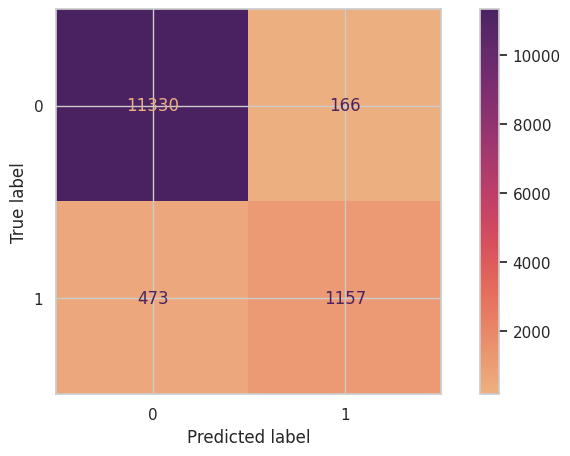

In [147]:
# confusion matrix

conf_matrix = metrics.confusion_matrix(test_y, preds)
cmap = sns.color_palette("flare", as_cmap=True)
disp = metrics.ConfusionMatrixDisplay(conf_matrix)

fig, ax = plt.subplots(figsize=(10, 5))
disp.plot(ax=ax, cmap=cmap)

plt.show()

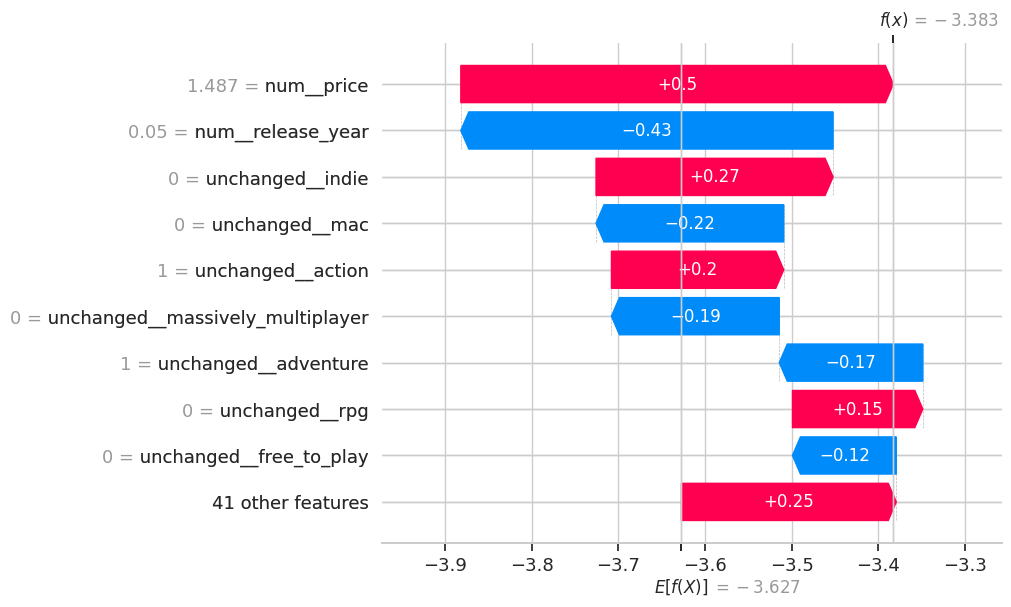

In [148]:
# feature importance using shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer(test_X)
shap.plots.waterfall(shap_values[0])

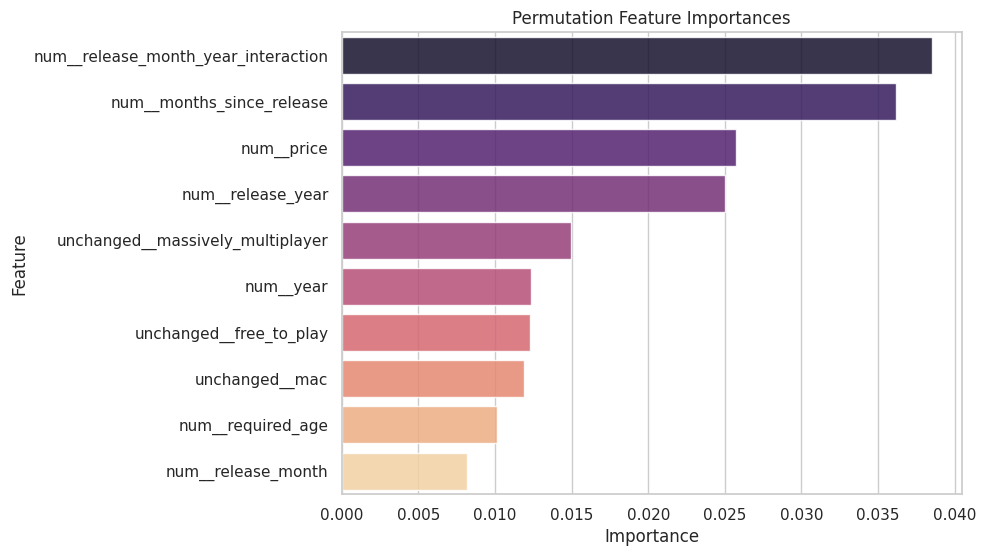

In [ ]:
# feature importance using permutation importance

importance = permutation_importance(classifier, test_X, test_y)

importances = pd.DataFrame(importance['importances_mean'], columns = ['avg_import'])
importances.index = classifier.feature_names_in_

importances = importances.sort_values('avg_import', ascending = False).head(10)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x='avg_import', y=importances.index, data=importances, palette='magma', alpha=0.85)
plt.title('Permutation Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [114]:
# if you want to export the model

with open('models/classifier.pkl', 'wb') as file:
    pickle.dump(classifier, file)

#### Testing Model 1
*   Using hypothetical future data

In [ ]:
# creating new empty df with the model features

classifier_future = pd.DataFrame(columns=model_features)

In [ ]:
classifier_features = classifier_future.columns.to_list()

def add_row() :
    new_row = {}
    for feature in classifier_features :
        # randomly sampling values from the dataset to create new data points
        new_row[feature] = np.random.choice(model_1[feature])

        if feature == 'free_to_play' :
            new_row[feature] = 0 if new_row['price'] > 0 else 1

        if feature == 'year' :
            new_row[feature] = np.random.randint(2024, 2031)

        if feature == 'release_year' :
            new_row[feature] = np.random.randint(2023, new_row['year'])

        if feature == 'months_since_release' :
            release_period = f"{new_row['release_year']}-{new_row['release_month']:02d}"
            period = f"{new_row['year']}-{new_row['month']:02d}"

            new_row[feature] = calculate_months(release_period, period)

        if feature == 'month_year_interaction' :
            new_row[feature] = new_row['month'] * new_row['year']

        if feature == 'release_month_year_interaction' :
            new_row[feature] = new_row['release_month'] * new_row['release_year']

    return new_row

In [ ]:
# creating n new data points
num_new_rows = 3000

for i in range(num_new_rows) :
    new_row = add_row()
    classifier_future.loc[len(classifier_future)] = new_row

In [ ]:
classifier_future

,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,sports,strategy,violent,month,year,release_month,release_year,months_since_release,month_year_interaction,release_month_year_interaction
0,0,29.99,0,0,0,0,0,0,0,0,...,0,0,0,5,2024,6,2023,11,10120,12138
1,17,59.99,0,0,0,0,0,0,0,0,...,0,0,0,4,2029,4,2025,48,8116,8100
2,17,19.99,0,0,0,0,0,0,0,0,...,0,0,0,6,2024,4,2023,14,12144,8092
3,0,24.99,0,0,0,0,0,0,0,0,...,0,1,0,2,2025,8,2023,18,4050,16184
4,0,18.99,0,0,0,0,0,0,0,0,...,1,1,0,6,2029,8,2027,22,12174,16216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0.00,0,0,0,0,0,0,0,0,...,0,1,0,4,2027,1,2026,15,8108,2026
2996,0,14.99,0,0,0,0,0,0,0,0,...,0,0,0,12,2025,7,2024,17,24300,14168
2997,0,19.99,0,0,0,0,0,0,0,0,...,0,0,0,7,2027,10,2025,21,14189,20250
2998,17,19.99,0,0,0,0,0,0,0,0,...,0,0,0,12,2027,7,2026,17,24324,14182


In [ ]:
# preprocessing

classifier_future_test = classifier_preproc.transform(classifier_future)

In [ ]:
# predictions

preds = classifier.predict(classifier_future_test)
classifier_future['is_rank'] = preds

classifier_future

,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,strategy,violent,month,year,release_month,release_year,months_since_release,month_year_interaction,release_month_year_interaction,is_rank
0,0,29.99,0,0,0,0,0,0,0,0,...,0,0,5,2024,6,2023,11,10120,12138,0
1,17,59.99,0,0,0,0,0,0,0,0,...,0,0,4,2029,4,2025,48,8116,8100,0
2,17,19.99,0,0,0,0,0,0,0,0,...,0,0,6,2024,4,2023,14,12144,8092,0
3,0,24.99,0,0,0,0,0,0,0,0,...,1,0,2,2025,8,2023,18,4050,16184,0
4,0,18.99,0,0,0,0,0,0,0,0,...,1,0,6,2029,8,2027,22,12174,16216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0.00,0,0,0,0,0,0,0,0,...,1,0,4,2027,1,2026,15,8108,2026,0
2996,0,14.99,0,0,0,0,0,0,0,0,...,0,0,12,2025,7,2024,17,24300,14168,0
2997,0,19.99,0,0,0,0,0,0,0,0,...,0,0,7,2027,10,2025,21,14189,20250,0
2998,17,19.99,0,0,0,0,0,0,0,0,...,0,0,12,2027,7,2026,17,24324,14182,0


In [ ]:
# counting how many 0s and how many 1s

counts = classifier_future['is_rank'].value_counts()
print(counts)

0    2943
1      57
Name: is_rank, dtype: int64


In [ ]:
# checking out the rows where the game does rank in the top 200

ranked_df = classifier_future[classifier_future['is_rank'] == 1]

ranked_df

,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,strategy,violent,month,year,release_month,release_year,months_since_release,month_year_interaction,release_month_year_interaction,is_rank
57,17,9.99,0,0,0,0,0,0,0,0,...,1,0,11,2026,4,2023,43,22286,8092,1
215,0,3.19,0,0,0,0,0,0,0,0,...,0,0,1,2028,7,2025,30,2028,14175,1
325,17,19.99,0,0,1,0,0,0,0,0,...,0,0,11,2025,3,2023,32,22275,6069,1
334,0,0.00,0,0,0,0,0,0,0,0,...,0,0,7,2029,10,2026,33,14203,20260,1
396,0,0.00,0,0,0,0,0,0,0,0,...,0,0,11,2024,8,2023,15,22264,16184,1
398,0,0.00,0,0,0,1,0,0,0,0,...,0,0,2,2024,10,2023,4,4048,20230,1
430,17,9.99,0,0,0,0,0,0,0,0,...,0,0,10,2030,5,2023,89,20300,10115,1
435,0,12.99,0,0,0,0,0,0,0,0,...,0,0,3,2029,2,2027,25,6087,4054,1
491,0,9.99,0,0,0,0,0,0,0,0,...,0,0,6,2025,2,2024,16,12150,4048,1
555,10,9.99,0,0,0,0,0,0,0,0,...,0,0,5,2030,8,2028,21,10150,16224,1


## Model 2: the probability of the non-zero values
*   "what rank will it be?"
*   remove all rows where stream stats are zero

In [ ]:
model_2 = final_df.copy()

model_2 = model_2[model_2['rank'] != 0] # removing all rows where it didn't rank

model_2 # 6512 x 51

,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,strategy,violent,month,year,release_month,release_year,months_since_release,rank,month_year_interaction,release_month_year_interaction
0,0,0.00,0,0,0,0,0,0,0,0,...,1,0,1,2016,7,2013,30,3,2016,14091
1,0,0.00,0,0,0,0,0,0,0,0,...,1,0,2,2016,7,2013,31,3,4032,14091
2,0,0.00,0,0,0,0,0,0,0,0,...,1,0,3,2016,7,2013,32,3,6048,14091
3,0,0.00,0,0,0,0,0,0,0,0,...,1,0,4,2016,7,2013,33,3,8064,14091
4,0,0.00,0,0,0,0,0,0,0,0,...,1,0,5,2016,7,2013,34,3,10080,14091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52497,0,0.00,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,122,18207,18207
52498,0,0.00,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,172,18207,18207
52500,0,0.00,0,0,0,0,0,0,0,0,...,1,0,9,2023,8,2023,1,183,18207,16184
52501,0,11.99,0,0,0,0,0,0,0,0,...,0,0,9,2023,9,2023,0,190,18207,18207


In [ ]:
# using the same features as model 1

train_X_raw, test_X_raw, train_y, test_y = train_test_split(model_2[model_features], model_2['rank'], random_state = 42)

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
     ("scaler", preprocessing.StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ('unchanged', 'passthrough', features)
    ]
)

In [ ]:
regressor_preproc = preprocessor.fit(train_X_raw)

train_X = regressor_preproc.transform(train_X_raw)
test_X = regressor_preproc.transform(test_X_raw)

#### HistGradientBoostingRegressor
Testing this model because it is an ensemble method just like HistGradientBoostingClassifier

In [ ]:
hgb_regressor = HistGradientBoostingRegressor().fit(train_X, train_y)

In [ ]:
preds = hgb_regressor.predict(test_X).astype(int)

# rmse
rmse = metrics.mean_squared_error(test_y, preds, squared=False)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 36.18680206559629


#### XGBoost
Trying out a different boosted ensemble method. Results are similar so I am using HistGradientBoostingRegressor for continuity.

In [ ]:
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_regressor.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds = xgb_regressor.predict(test_X).astype(int)

rmse = metrics.mean_squared_error(test_y, preds, squared=False)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 35.50717130044597


#### HistGradientBoostingRegressor
Decided on this model because the RMSE for both were similar

In [ ]:
# hyperparameter tuning using bayes (only using bayes now because from previous experience it's more optimized)

param_bayes = {
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'max_iter': (50, 200),
    'max_depth': (3, 7),
    'l2_regularization': (0.0, 0.2)
}

regressor_bayes = HistGradientBoostingRegressor()

# this takes around 10 min
bayes_search = BayesSearchCV(
    regressor_bayes,
    param_bayes,
    scoring='neg_mean_squared_error', # rmse for evaluation metric
    n_iter=50,
    cv=5
)

bayes_search.fit(train_X, train_y)
print("Best Hyperparameters:", bayes_search.best_params_)

best_model = bayes_search.best_estimator_
pred = best_model.predict(test_X)
rmse = metrics.mean_squared_error(test_y, pred, squared=False)
print("Root Mean Squared Error on Test Set:", rmse)

Best Hyperparameters: OrderedDict([('l2_regularization', 0.2), ('learning_rate', 0.12502648010945355), ('max_depth', 7), ('max_iter', 200)])
Root Mean Squared Error on Test Set: 35.85164203946539


In [ ]:
regressor = HistGradientBoostingRegressor(
    **bayes_search.best_params_).fit(train_X, train_y)

In [ ]:
preds = regressor.predict(test_X)

In [ ]:
test_pred = test_X.copy()
test_pred['truth'] = test_y
test_pred['predictions_regressor'] = preds.astype(int)

In [ ]:
test_pred

,num__required_age,num__price,num__month,num__year,num__release_month,num__release_year,num__months_since_release,num__month_year_interaction,num__release_month_year_interaction,unchanged__aspyr,...,unchanged__nudity,unchanged__racing,unchanged__rpg,unchanged__sexual_content,unchanged__simulation,unchanged__sports,unchanged__strategy,unchanged__violent,truth,predictions_regressor
2277,-0.597131,-1.142823,-0.407305,0.610568,1.156549,0.137089,0.150874,-0.406314,1.158227,0,...,0,0,0,0,1,0,0,0,62,73
21199,-0.597131,-1.142823,0.767004,-0.286144,1.156549,0.137089,-0.414794,0.766438,1.158227,0,...,0,0,0,0,0,0,1,0,137,160
50826,-0.597131,1.920567,-0.407305,1.058924,-0.535404,1.627609,-1.037028,-0.405587,-0.531597,0,...,0,0,0,0,0,0,0,0,93,99
49872,-0.597131,0.694966,1.354158,1.058924,1.156549,1.329505,-0.697628,1.358340,1.164383,0,...,0,0,0,0,1,0,0,0,145,175
96,1.679310,0.069909,-0.700883,-1.631212,1.156549,-0.459119,-0.895611,-0.703064,1.155149,1,...,0,0,0,0,0,0,0,0,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,-0.597131,1.307766,0.179849,-1.631212,-0.817396,-0.459119,-0.612777,0.176282,-0.818434,0,...,0,0,0,0,1,0,0,0,83,105
42908,-0.597131,0.082165,-0.700883,0.162212,1.156549,0.733297,-0.895611,-0.700738,1.161305,0,...,0,0,0,0,0,0,1,0,70,79
33532,-0.597131,0.388566,0.179849,-0.734500,-0.535404,0.435193,-0.980461,0.178317,-0.534395,0,...,0,0,0,0,1,0,0,0,175,146
17075,-0.597131,-0.224235,-0.994460,-1.182856,0.874557,-0.161015,-0.895611,-0.995743,0.874607,0,...,0,1,0,0,1,0,0,0,158,153


In [ ]:
# rmse

rmse = metrics.mean_squared_error(test_y, preds, squared=False)
print(rmse) # on a scale from 1-200

35.85164203946539


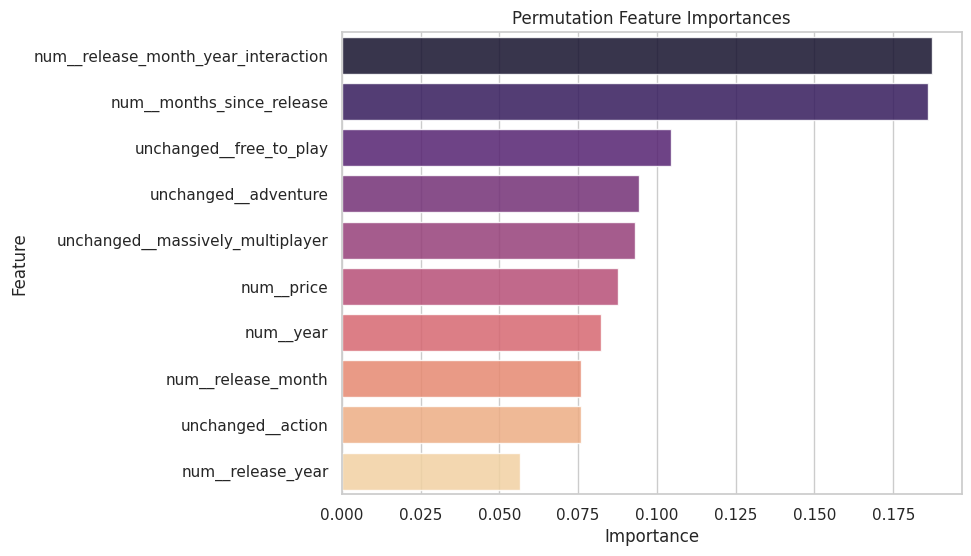

In [ ]:
# feature importance using permutation importance

importance = permutation_importance(regressor, test_X, test_y)

importances = pd.DataFrame(importance['importances_mean'], columns = ['avg_import'])
importances.index = regressor.feature_names_in_

importances = importances.sort_values('avg_import', ascending = False).head(10)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x='avg_import', y=importances.index, data=importances, palette='magma', alpha=0.85)
plt.title('Permutation Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

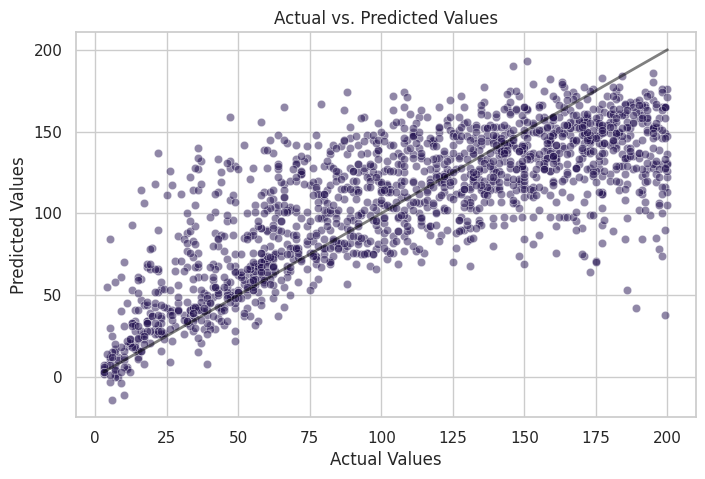

In [ ]:
# plotting the results of actual vs predicted rankings

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.set_palette("magma")

sns.scatterplot(x=test_pred['truth'], y=test_pred['predictions_regressor'], alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.plot([min(test_pred['truth']), max(test_pred['truth'])], [min(test_pred['truth']), max(test_pred['truth'])], linestyle='-', color='black', linewidth=2, alpha=0.5)

plt.show()

In [115]:
# if you want to export the model

with open('models/regressor.pkl', 'wb') as file:
    pickle.dump(regressor, file)

#### Testing Model 2
*   Using hypothetical future data
*   Continuing with ranked_df from Testing Model 1

In [ ]:
regressor_future = ranked_df.copy() # using rows that the classifier said would rank in top 200

In [ ]:
regressor_future

,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,strategy,violent,month,year,release_month,release_year,months_since_release,month_year_interaction,release_month_year_interaction,is_rank
57,17,9.99,0,0,0,0,0,0,0,0,...,1,0,11,2026,4,2023,43,22286,8092,1
215,0,3.19,0,0,0,0,0,0,0,0,...,0,0,1,2028,7,2025,30,2028,14175,1
325,17,19.99,0,0,1,0,0,0,0,0,...,0,0,11,2025,3,2023,32,22275,6069,1
334,0,0.00,0,0,0,0,0,0,0,0,...,0,0,7,2029,10,2026,33,14203,20260,1
396,0,0.00,0,0,0,0,0,0,0,0,...,0,0,11,2024,8,2023,15,22264,16184,1
398,0,0.00,0,0,0,1,0,0,0,0,...,0,0,2,2024,10,2023,4,4048,20230,1
430,17,9.99,0,0,0,0,0,0,0,0,...,0,0,10,2030,5,2023,89,20300,10115,1
435,0,12.99,0,0,0,0,0,0,0,0,...,0,0,3,2029,2,2027,25,6087,4054,1
491,0,9.99,0,0,0,0,0,0,0,0,...,0,0,6,2025,2,2024,16,12150,4048,1
555,10,9.99,0,0,0,0,0,0,0,0,...,0,0,5,2030,8,2028,21,10150,16224,1


In [ ]:
# preprocessing

regressor_future_test = regressor_preproc.transform(regressor_future)

In [ ]:
preds = regressor.predict(regressor_future_test).astype(int)
ranked_df['pred_rank'] = preds

ranked_df = ranked_df.reset_index(drop=True)

ranked_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,required_age,price,aspyr,bethesda_game_studios,capcom,feral_interactive,firaxis_games,frontier_developments,gearbox_software,jackbox_games,...,violent,month,year,release_month,release_year,months_since_release,month_year_interaction,release_month_year_interaction,is_rank,pred_rank
0,17,9.99,0,0,0,0,0,0,0,0,...,0,11,2026,4,2023,43,22286,8092,1,122
1,0,3.19,0,0,0,0,0,0,0,0,...,0,1,2028,7,2025,30,2028,14175,1,148
2,17,19.99,0,0,1,0,0,0,0,0,...,0,11,2025,3,2023,32,22275,6069,1,157
3,0,0.00,0,0,0,0,0,0,0,0,...,0,7,2029,10,2026,33,14203,20260,1,82
4,0,0.00,0,0,0,0,0,0,0,0,...,0,11,2024,8,2023,15,22264,16184,1,144
5,0,0.00,0,0,0,1,0,0,0,0,...,0,2,2024,10,2023,4,4048,20230,1,113
6,17,9.99,0,0,0,0,0,0,0,0,...,0,10,2030,5,2023,89,20300,10115,1,126
7,0,12.99,0,0,0,0,0,0,0,0,...,0,3,2029,2,2027,25,6087,4054,1,93
8,0,9.99,0,0,0,0,0,0,0,0,...,0,6,2025,2,2024,16,12150,4048,1,48
9,10,9.99,0,0,0,0,0,0,0,0,...,0,5,2030,8,2028,21,10150,16224,1,121
